## A Convolutional Neural Network in *Pytorch*

### Pytorch is awesome for deep learning for several reasons
* It is Python based and at its core is essentially Python
* Enables GPU accelerated tensor computations
* Provides a rich API for neural networks
* Computational graphs are dynamic, not static 
* Automatic differentiation
* Moving between CPU and GPU based environments is very easy

### We will be using the MNIST digit dataset in this example
[MNIST](http;//yann.lecun.com/exdb/mnist/)

#### First step is to import the requisite torch and other libraries

In [94]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Next step is to create the training and test datasets from the MNIST dataset which is available to Pytorch

In [95]:
train_dataset=dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset=dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

Processing...
Done!


In [96]:
# number of images in train and test data sets
print(len(train_dataset))
print(len(test_dataset))

60000
10000


In [97]:
# determine the image labels in dataset -- each image is classified into 10 categories
unique_labels=set()
for i in range(len(train_dataset)):
    unique_labels.add(train_dataset[i][1].numpy().tolist())
unique_labels

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [98]:
# look at some of the images
# check size of image
train_dataset[0][0].numpy().shape

(1, 28, 28)

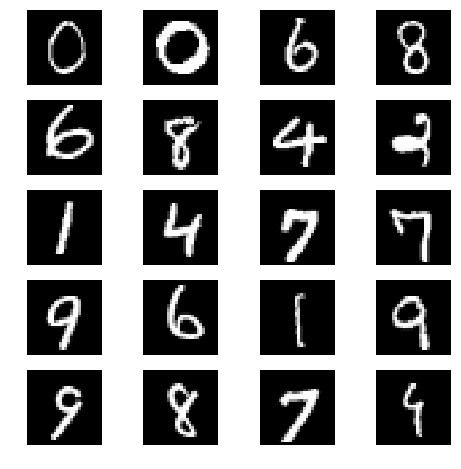

In [99]:
# review 20 images
fig=plt.figure(figsize=(8,8))
for i in range(1,21):
    image_num = np.random.randint(len(train_dataset))
    image = train_dataset[image_num][0][0,:,:]
    fig.add_subplot(5, 4, i)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

#### Now we are going to define various parameters of the training e.g batch size which is used to define the data loader iterable, the

#### number of epochs (which also simultaneously determines the number of iterations. So e.g. if we have a 1000 observations in 

#### the training dataset, a batch size of 100 and 10 epochs then the total number of iterations would be 10*(1000/100) = 100

In [101]:
batch_size=100
n_iters=6000
num_epochs=n_iters/(len(train_dataset)/batch_size)
num_epochs=int(num_epochs)
num_epochs

10

### Now we create an iterable out of the datasets so that we can perform training a batch at a time. Note that
* For training dataset, shuffle is set to True so that dataset is shuffled at the beginning of every epoch
* Do not need to do above for test dataset since we just apply model to that in single epoch

In [103]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Now we create the model class in Pytorch. For this particular example we will use
* 2 convolutional layers, one with 16 filters and the other with 32 filters
    * kernel/filter size is 5x5
    * stride of 1
    * padding of 2 to ensure same output size (kernel-1)/2
* ReLU non-linearity
* Max pooling with a kernel of 2x2
* One fully connected hidden layer with an output of 150
    * followed by ReLU non linearity
* fully connected linear layer with an output of 10 (since 10 digits)

In [104]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # in channels =1 because RGB, out channels upto us but if we use 16 kernels we will get 16 out channels
        self.cnn1=nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        # non linearity
        self.relu1=nn.ReLU()
        # maxpooling layer
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2=nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2=nn.ReLU()
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        self.fc1=nn.Linear(in_features=32*7*7, out_features=150)
        self.relu3=nn.ReLU()
        
        self.fc2=nn.Linear(in_features=150, out_features=10)
        
    def forward(self, x):
        out=self.cnn1(x)
        out=self.relu1(out)
        out=self.maxpool1(out)
        out=self.cnn2(out)
        out=self.relu2(out)
        out=self.maxpool2(out)
        # below line of code does flattening for input into fully connected layers
        out=out.view(out.size(0),-1)
        out=self.fc1(out)
        out=self.relu3(out)
        out=self.fc2(out)
        return out


#### Instantiate the model class and print out the parameters and layers (architecture)

In [105]:
model=CNNModel()

print(model.parameters())
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())
    
print(model)

<generator object Module.parameters at 0x000001F5B1D82BA0>
8
torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([150, 1568])
torch.Size([150])
torch.Size([10, 150])
torch.Size([10])
CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=150, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=150, out_features=10, bias=True)
)


#### Set loss criterion, learning rate and instantiate optimizer
* Cross Entropy Loss criterion for classification
* Start with LR=1e-3
* SGD optimizer -- stochastic gradient descent

In [106]:
criterion=nn.CrossEntropyLoss()

learning_rate=0.01

optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)

### Train the model and compute accuracy metrics every 600 iterations

In [107]:
# training
iter=0
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        # clear gradients
        optimizer.zero_grad()
        # forward pass
        outputs=model(images)
        # calculate loss--this will do softmax and cross entropy
        loss=criterion(outputs, labels)
        # get gradients
        loss.backward()
        # update parameters
        optimizer.step()
        
        # keep track of iterations
        iter+=1
        
        #calculate accuracy every 600 iterations
        if iter%600 == 0:
            correct=0
            total=0
            # iterate through test dataset
            for images, labels in test_loader:
                outputs=model(images)
                # get predictions
                # torch.max(outputs, 1) will return two elements, first the value and second the index of the row max
                _, predicted=torch.max(outputs,1)
                total+=labels.size(0)
                correct+=(predicted==labels).sum()
            accuracy=100*correct.double()/total
         
            print(f'Iteration # {iter}, Loss is {loss.data}, Accuracy of {accuracy}')

Iteration # 600, Loss is 0.49180468916893005, Accuracy of 87.1
Iteration # 1200, Loss is 0.2298184186220169, Accuracy of 92.3
Iteration # 1800, Loss is 0.1684103012084961, Accuracy of 94.0
Iteration # 2400, Loss is 0.2093038409948349, Accuracy of 95.4
Iteration # 3000, Loss is 0.09356354922056198, Accuracy of 95.99
Iteration # 3600, Loss is 0.13440671563148499, Accuracy of 96.78
Iteration # 4200, Loss is 0.14215579628944397, Accuracy of 96.63
Iteration # 4800, Loss is 0.0869639664888382, Accuracy of 97.43
Iteration # 5400, Loss is 0.12234852463006973, Accuracy of 97.6
Iteration # 6000, Loss is 0.0459846630692482, Accuracy of 97.74
